In [166]:
# Based on https://github.com/GoogleCloudPlatform/ml-design-patterns/blob/master/03_problem_representation/rebalancing.ipynb.
#   !gsutil cp gs://ml-design-patterns/fraud_data_kaggle.csv .

import xgboost as xgb
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras

In [167]:
SEED = 42
NROWS = None

def process_data(df: pd.DataFrame) -> pd.DataFrame:
    df.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'], inplace=True)
    df = pd.get_dummies(df)

    target = df.isFraud
    df = df.drop(columns=['isFraud'])
    sc = StandardScaler()    
    df[df.columns] = sc.fit_transform(df)
    df['isFraud'] = target
    return df

def fraud_rate_df(df: pd.DataFrame) -> float:
    fraud_df = df[df['isFraud'] == 1]
    return len(fraud_df)/len(df)

def fraud_rate(y) -> float:
    fraud_indices = np.where(y == 1)[0]
    return len(fraud_indices) / len(y) # type: ignore

def train_split(df: pd.DataFrame):
    y = df.isFraud.values
    X_train, X_test, _, y_test = train_test_split(df, y, stratify=y, test_size=0.2, random_state=SEED)
    train_df = pd.DataFrame(data=X_train, columns=df.columns)
    X_test.drop(columns=['isFraud'], inplace=True) # type: ignore
    return train_df, X_test, y_test

# This is from the sklearn docs
# https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    if normalize:
        # cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 3)
        cm = cm / cm.sum(axis=1, keepdims=True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]:.3f}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")                 

    plt.tight_layout()  
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def train_and_eval(df: pd.DataFrame, should_down_sample: bool=False, frac: float=1.0, use_class_weight=False, initialize_bias=False):

    train_df, X_test, y_test = train_split(df)

    # down_sample
    if should_down_sample:
        print(f"Down sample train {frac}")
        fraud = train_df[train_df['isFraud'] == 1]
        not_fraud = train_df[train_df['isFraud'] == 0]
        not_fraud_sample = not_fraud.sample(random_state=SEED, frac=frac)
        train_df = pd.concat([not_fraud_sample,fraud])
        train_df = shuffle(train_df, random_state=SEED)    
    else:
        print("Original train")

    X_train = train_df.drop(columns=['isFraud']).values
    y_train = train_df.isFraud.values

    print(f'Fraud Rate in (all, train, test)=({fraud_rate_df(df):.5f}, {fraud_rate(y_train):.5f}, {fraud_rate(y_test):.5f})')

    if use_class_weight:
        minor_weight = 1 / fraud_rate(y_train) / 2
        major_weight = 1 / (1 - fraud_rate(y_train)) / 2
        class_weight = {1: minor_weight, 0: major_weight}
    else:
        class_weight = None

    if initialize_bias:
        model = keras.Sequential([
            keras.layers.Dense(10, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'),
            keras.layers.Dense(1, activation='sigmoid')
        ])    
    else:
        len_minority = len(train_df[train_df['isFraud'] == 1])
        len_majority = len(train_df[train_df['isFraud'] == 0])        
        bias_value = np.log(len_minority / len_majority)
        model = keras.Sequential([
            keras.layers.Dense(10, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'),
            keras.layers.Dense(1, activation='sigmoid', bias_initializer=keras.initializers.Constant(value=bias_value))
        ])    

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
    model.fit(X_train, y_train, epochs=2, batch_size=512, verbose=0, class_weight=class_weight)

    y_pred = model.predict(X_test)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.reshape(-1).astype(int)
    print(f'label={y_test} pred={y_pred}')
    print(f'accuracy_score: {accuracy_score(y_test, y_pred):.4f}')    
    print(f'precision_score: {precision_score(y_test, y_pred):.4f}')
    print(f'recall_score: {recall_score(y_test, y_pred):.4f}')    
    print(f'f1_score: {f1_score(y_test, y_pred):.4f}')
    cm = confusion_matrix(y_test, y_pred)
    print(f'cm={cm}')

    classes = ['not fraud', 'fraud']    
    plot_confusion_matrix(cm, classes, normalize=True)

In [168]:
df = pd.read_csv('/kaggle/input/fraud_data_kaggle.csv', nrows=NROWS)
df = process_data(df)
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud
0,-1.703042,-0.281560,-0.229810,-0.237622,-0.323814,-0.333411,-0.530965,-0.736484,-0.08096,1.399036,-0.302345,0
1,-1.703042,-0.294767,-0.281359,-0.285812,-0.323814,-0.333411,-0.530965,-0.736484,-0.08096,1.399036,-0.302345,0
2,-1.703042,-0.297555,-0.288654,-0.292442,-0.323814,-0.333411,-0.530965,-0.736484,-0.08096,-0.714778,3.307478,1
3,-1.703042,-0.297555,-0.288654,-0.292442,-0.317582,-0.333411,-0.530965,1.357803,-0.08096,-0.714778,-0.302345,1
4,-1.703042,-0.278532,-0.274329,-0.282221,-0.323814,-0.333411,-0.530965,-0.736484,-0.08096,1.399036,-0.302345,0


Original train
Fraud Rate in (all, train, test)=(0.00129, 0.00129, 0.00129)


2021-11-30 08:25:57.128082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-30 08:27:04.966644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


label=[0 0 0 ... 0 0 0] pred=[0 0 0 ... 0 0 0]
accuracy_score: 0.9993
precision_score: 0.9752
recall_score: 0.4540
f1_score: 0.6196
cm=[[1270862      19]
 [    897     746]]


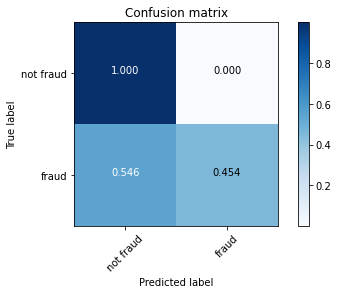

In [169]:
# Use the imblanced train data as is.
train_and_eval(df)

Original train
Fraud Rate in (all, train, test)=(0.00129, 0.00129, 0.00129)


2021-11-30 08:27:38.528612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-30 08:28:47.997349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


label=[0 0 0 ... 0 0 0] pred=[0 0 0 ... 0 0 1]
accuracy_score: 0.9170
precision_score: 0.0140
recall_score: 0.9105
f1_score: 0.0275
cm=[[1165364  105517]
 [    147    1496]]


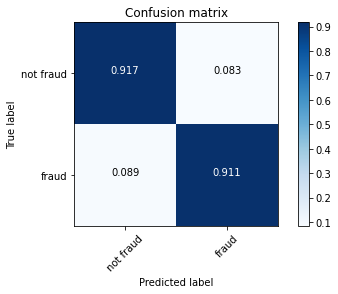

In [170]:
# Based on the isFraud rate, we pass class_weight to Keras.
train_and_eval(df, use_class_weight=True)

Original train
Fraud Rate in (all, train, test)=(0.00129, 0.00129, 0.00129)


2021-11-30 08:29:21.105189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-30 08:30:31.156252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


label=[0 0 0 ... 0 0 0] pred=[0 0 0 ... 0 0 1]
accuracy_score: 0.9381
precision_score: 0.0190
recall_score: 0.9276
f1_score: 0.0373
cm=[[1192241   78640]
 [    119    1524]]


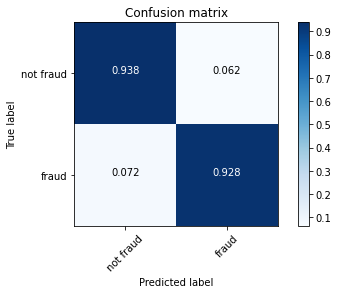

In [171]:
# Based on the isFraud rate, we pass class_weight to Keras and use initial bias value.
train_and_eval(df, use_class_weight=True, initialize_bias=True)

Down sample train 0.0001
Fraud Rate in (all, train, test)=(0.00129, 0.92823, 0.00129)


2021-11-30 08:31:04.981915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-30 08:31:05.446658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


label=[0 0 0 ... 0 0 0] pred=[1 1 1 ... 1 1 1]
accuracy_score: 0.0013
precision_score: 0.0013
recall_score: 1.0000
f1_score: 0.0026
cm=[[     16 1270865]
 [      0    1643]]


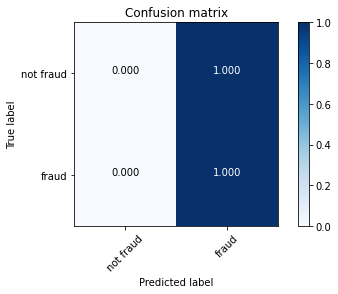

In [172]:
# We down sample the train data.
train_and_eval(df, should_down_sample=True, frac=0.0001)

Down sample train 0.003
Fraud Rate in (all, train, test)=(0.00129, 0.30109, 0.00129)


2021-11-30 08:31:38.822019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-30 08:31:39.319104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


label=[0 0 0 ... 0 0 0] pred=[1 0 0 ... 0 0 1]
accuracy_score: 0.9575
precision_score: 0.0170
recall_score: 0.5618
f1_score: 0.0330
cm=[[1217487   53394]
 [    720     923]]


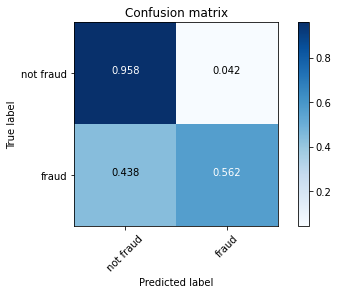

In [173]:
# We down sample the train data.
train_and_eval(df, should_down_sample=True, frac=0.003)

Down sample train 0.002
Fraud Rate in (all, train, test)=(0.00129, 0.39254, 0.00129)


2021-11-30 08:32:13.415078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-30 08:32:13.914875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


label=[0 0 0 ... 0 0 0] pred=[1 0 0 ... 0 0 1]
accuracy_score: 0.9191
precision_score: 0.0112
recall_score: 0.7048
f1_score: 0.0220
cm=[[1168482  102399]
 [    485    1158]]


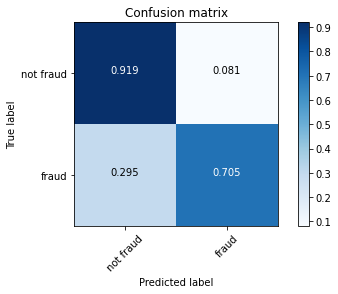

In [174]:
# We down sample the train data.
train_and_eval(df, should_down_sample=True, frac=0.002)

Down sample train 0.001
Fraud Rate in (all, train, test)=(0.00129, 0.56375, 0.00129)


2021-11-30 08:32:47.451775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-30 08:32:47.800415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


label=[0 0 0 ... 0 0 0] pred=[1 0 1 ... 1 1 1]
accuracy_score: 0.2024
precision_score: 0.0016
recall_score: 0.9915
f1_score: 0.0032
cm=[[ 255914 1014967]
 [     14    1629]]


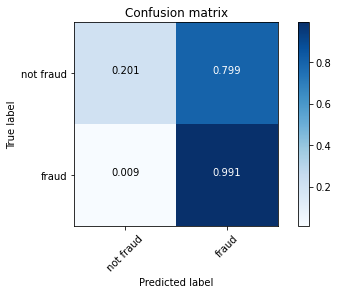

In [175]:
# We down sample the train data.
train_and_eval(df, should_down_sample=True, frac=0.001)

Down sample train 0.002
Fraud Rate in (all, train, test)=(0.00129, 0.39254, 0.00129)


2021-11-30 08:33:21.385161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-30 08:33:21.921622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


label=[0 0 0 ... 0 0 0] pred=[1 0 0 ... 0 0 1]
accuracy_score: 0.7765
precision_score: 0.0051
recall_score: 0.8953
f1_score: 0.0102
cm=[[986696 284185]
 [   172   1471]]


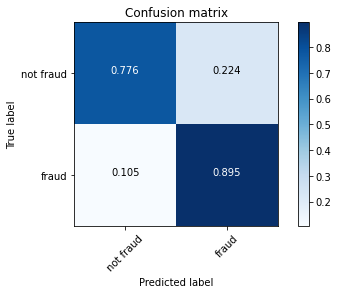

In [176]:
# We first down sample the train data, then also use the class_weight.
train_and_eval(df, should_down_sample=True, frac=0.002, use_class_weight=True)